In [1]:
pip install audiomentations

Note: you may need to restart the kernel to use updated packages.


# Useful resources:
**Notebooks :**
[ https://www.kaggle.com/stegzz/readable-keras-resnet50-model ]
[ https://www.kaggle.com/alkahapur/birdspicies-prediction-using-tensorflow-and-cnn ]
[ https://www.kaggle.com/dimitreoliveira/rainforest-audio-classification-tf-improved ]

**Papers**
[ http://ceur-ws.org/Vol-1866/paper_143.pdf ]
[ https://arxiv.org/pdf/1706.07156.pdf%5D ]

# Importing Libraries

In [2]:
import os ,time,gc
import glob,math
import pandas as pd  
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt 
import seaborn as sns 
from IPython.display import Audio
from tqdm import tqdm
from skimage.transform import resize

import librosa
import librosa.display as ld 
import soundfile as sf
from audiomentations import Compose,AddGaussianSNR,Shift,TimeStretch,TimeMask,FrequencyMask,PolarityInversion


import tensorflow as tf 
from tensorflow import keras 
from keras import regularizers
from keras import layers
from sklearn.preprocessing import StandardScaler


**Loading Data**

In [3]:
train_fp=pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv') #false positives 
train_tp=pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')  #true positives 

#training path 
train_path='../input/rfcx-species-audio-detection/train/'
test_path='../input/rfcx-species-audio-detection/test/'

In [4]:
print(f'Number of True positives = {len(train_tp)} \n Number of false positives = {len(train_fp)}')

Number of True positives = 1216 
 Number of false positives = 7781


In [5]:
#Parameters:
# n_mfcc=30
n_fft=2048
hop_len=512
# sr=int(train_tp.f_max.max()*1.5)  #setting the sample rate according to the max value of frequency
sr=44200
shape_1=(256,512)

min_freq=int(train_tp['f_min'].min() * 0.75)       #a buffer around min and max freq values.
max_freq=int(train_tp['f_max'].max() * 1.25)

# Data overview:

**Columns**

    recording_id - unique identifier for recording
    species_id - unique identifier for species
    songtype_id - unique identifier for songtype
    t_min - start second of annotated signal
    f_min - lower frequency of annotated signal
    t_max - end second of annotated signal
    f_max- upper frequency of annotated signal
    is_tp- [tfrecords only] an indicator of whether the label is from the train_tp (1) or train_fp (0) file.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'train_true_positives')

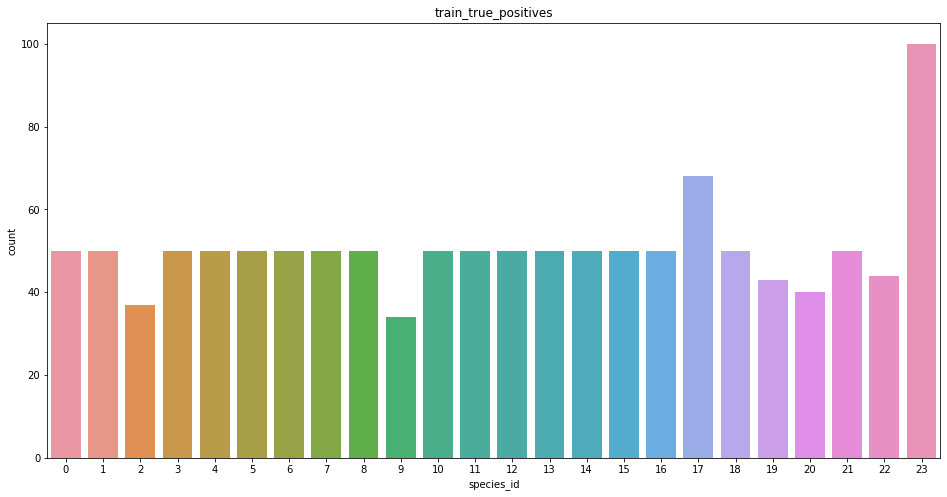

In [6]:
#True positive Class balance 
plt.figure(figsize=(16,8))
sns.countplot(train_tp.species_id)
plt.title('train_true_positives')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'train_false_positives')

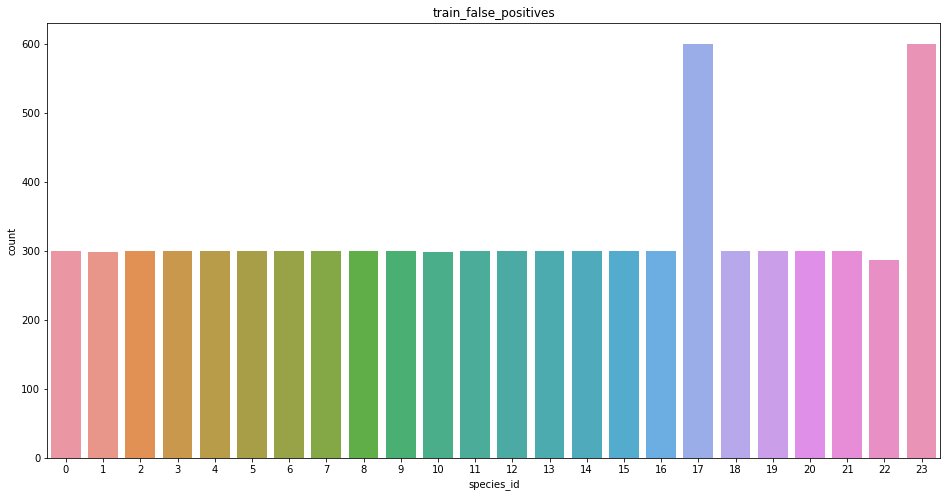

In [7]:
#False Positives
plt.figure(figsize=(16,8))
sns.countplot(train_fp.species_id)
plt.title('train_false_positives')

**Lets see (I mean hear.) a sample audio recording from the data .**

In [8]:
file_path=train_path + '/' +'006ab765f.flac'
Audio(file_path)

**Waveplot and Power spectrum**

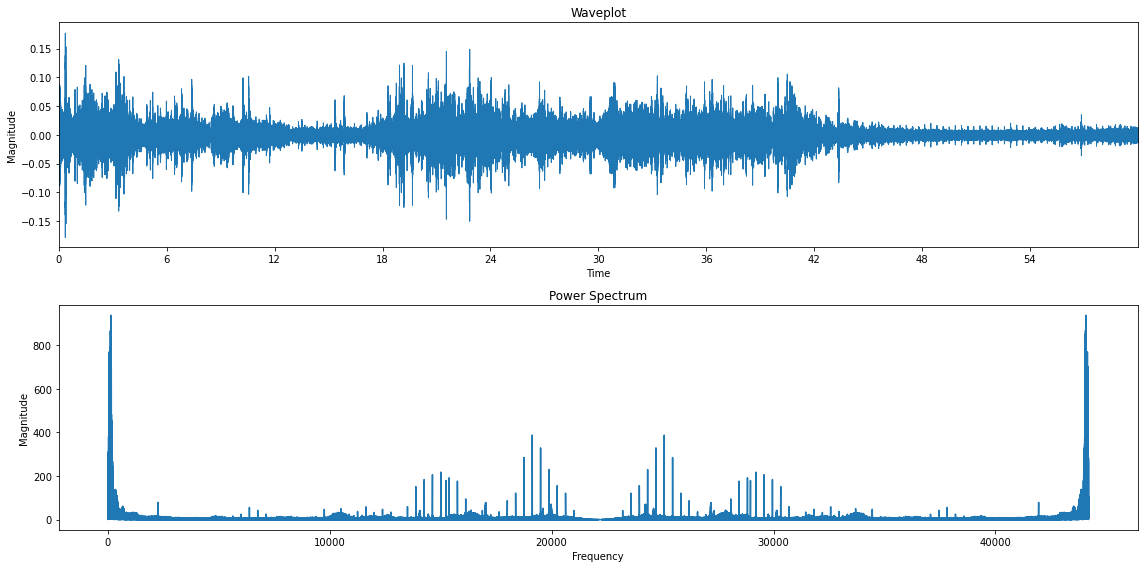

In [9]:
#loading file
signal,sr=librosa.load(file_path,sr=sr)

plt.figure(figsize=(16,8))

#waveplot:
plt.subplot(2,1,1)
ld.waveplot(signal,sr)
plt.ylabel('Magnitude')
plt.title('Waveplot')

#fast fourier transform:

fft=np.fft.fft(signal)
mag=np.abs(fft)
freq=np.linspace(0,sr,len(mag))
plt.subplot(2,1,2)
plt.plot(freq,mag)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum')
plt.tight_layout()
plt.show()

**SHORT TIME FOURIER TRANSFORM(STFT)**

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


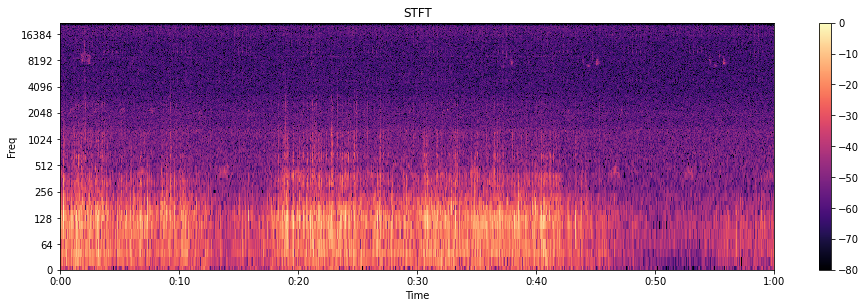

[Text(0.5, 1.0, 'Mel spectrogram display')]

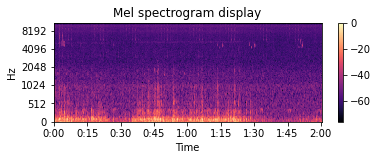

In [10]:
#short time fourier transform:
stft=librosa.core.stft(signal,hop_length=hop_len,n_fft=n_fft)
spectrogram=librosa.amplitude_to_db(np.abs(stft),ref=np.max)

#display_spectrogram:
plt.figure(figsize=(16,10))

ax=plt.subplot(2,1,1)
img=ld.specshow(spectrogram,sr=sr,hop_length=hop_len,ax=ax,x_axis='time',y_axis='log')
plt.xlabel('Time')
plt.ylabel('Freq')
plt.colorbar(img)
plt.title('STFT')
plt.show()


ax=plt.subplot(2,1,2)
M = librosa.feature.melspectrogram(y=signal, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = ld.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
plt.colorbar(img)
ax.set(title='Mel spectrogram display')


**MEL Frequency Cepstral Coefficients (MFCC)**

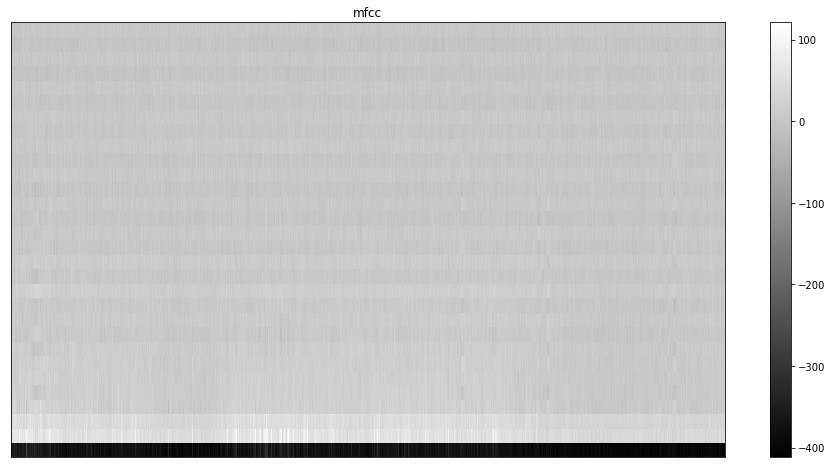

In [11]:
#MFCC:

mfcc=librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=hop_len,n_mfcc=30)

fig,ax=plt.subplots(figsize=(16,8))
img=ld.specshow(mfcc,sr=sr,hop_length=hop_len,ax=ax,cmap='gray')
plt.title('mfcc')
plt.colorbar(img)
plt.show()

**lets see patterns in STFT spectrograms**

In [12]:
def plot_stft(df,trainpath,n_fft=2048,hop_len=512,sr=sr):
    plt.subplots(25,1,figsize=(16,8*25))
    for i,row in df.iterrows():
        rec_id=row['recording_id']
        start=int(row['t_min']*0.75)
        end=int(row['t_max']*1.25)
        idx=row['species_id']
        
        #loading files
        fpath=os.path.join(trainpath +'/'+f'{rec_id}.flac')
        sig,sr=librosa.load(fpath,sr=sr)
        sig=sig[sr*start:sr*end]     #limiting signal to around  t_min and t_max
        
        
        
        #plotting stft:
        stft=librosa.core.stft(sig,hop_length=hop_len,n_fft=n_fft)
        spectrogram=librosa.amplitude_to_db(np.abs(stft),ref=np.max)
        ax=plt.subplot(25,1,i+1)
        
        img=ld.specshow(spectrogram,sr=sr,hop_length=hop_len,ax=ax,x_axis='time',y_axis='log')
        plt.xlabel('Time')
        plt.ylabel('Freq')
        plt.colorbar(img)
        plt.title(f'Species Id {idx}')
    plt.show()

# plot_stft(df=train_tp[:25],trainpath=train_path,n_fft=2048,hop_len=512,sr=sr)
gc.collect()

4998

# Audio Augmentation.
Similar to the approach used for image classification, Audio Augmentation is also a useful approach to increase the robustness of the model and have more examples for the model to train upon. This is especially important because I have not figured out a approach to use False positive data for training.

In [13]:
#Audio Augmentation:
augmentations = Compose([
            TimeMask(min_band_part=0.005, max_band_part=0.10, p=0.5),
            FrequencyMask(min_frequency_band=0.005, max_frequency_band=0.10, p=0.5),
            TimeStretch(min_rate=0.8,max_rate=1.25,p=0.5),
            AddGaussianSNR(min_SNR=0.001, max_SNR=.75, p=0.5),
            PolarityInversion(p=0.5),
            Shift(min_fraction=-0.25,max_fraction=0.25,p=0.5)])



**I would not be using MFCCs because the model has not been performing all that well on MFCCs. This belief is reinforced in this paper [ https://arxiv.org/pdf/1706.07156.pdf ] which claims STFT spectrograms do a better job than baseline MFCCs. **

In [14]:
# def save_mfccs(path=train_path,df=train_tp,n_mfcc=n_mfcc,hop_len=hop_len,sr=sr,n_fft=n_fft):
#     data={'mfcc':[],'label':[]}
#     mfccs,labels=[],[]
    
#     #loading audio files:
#     for i,row in df.iterrows():
#         rec_id=row['recording_id']
#         filepath=os.path.join(path +'/' +f'{rec_id}.flac')
#         start,end=math.floor(row['t_min']),math.ceil(row['t_max']) #taking signal slice around t_min and t_max 
        
#         #loading files:
#         signal,sr=librosa.load(filepath,sr=sr)
#         signal=signal[start:end]
        
#         signal=augmentations(signal,sample_rate=sr)
        
#         #extracting mfccs:
#         mfcc= librosa.feature.mfcc(signal,sr=sr,n_mfcc=n_mfcc,hop_length=hop_len,n_fft=2048)
        
#         #appending to list:
#         mfccs.append(mfcc)
#         labels.append(row['species_id'])
#     data['mfcc']=mfccs
#     data['label']=labels
#     print('MFCCs extracted')
#     return data 

# mfcc=save_mfccs()

# Extracting mel-scaled-STFT 

In [15]:
def save_stft(df=train_tp,path=train_path,sr=sr,augment=True,power=1.5,shape=shape_1,expand_dim=True):
    #dict to store values: 
    data={'mel-stft':[] ,'label':[]}
    stfts,labels=[],[]
    
    #loading audio files:
    for i,row in df.iterrows():
        try:
    
            rec_id=row['recording_id']
            label=row['species_id']
            filepath=os.path.join(path +'/' +f'{rec_id}.flac')

            #the starting and end of species sound provided in dataframe.
            start,end=row['t_min'],row['t_max'] 

            #taking signal slice around t_min and t_max 
            buffer1=np.random.uniform(2,6)
            buffer2=np.random.uniform(2,6)
            #buffer around start
            if start<6:
                start=0
            else:
                start=math.floor(start-buffer1) * sr

            #buffer around end

            if end > 54:
                end = 60
            else:
                end=math.ceil(end + buffer2) * sr

             #loading files:
           
            signal,sr=librosa.load(filepath,sr=sr)
            signal=signal[start:end]

            #augmenting data
            if augment==True:
                signal=augmentations(signal,sample_rate=sr)

            #spectrogram
            stft = librosa.feature.melspectrogram(signal, sr=sr,n_mels=shape[0],power=power,
                                                 fmin=min_freq,fmax=max_freq)
            stft_db=librosa.core.amplitude_to_db(np.abs(stft))

            #reshape:
            stft_db= resize(stft_db,shape)

            #expand_dims
            if expand_dim==True:
                stft_db=np.stack((stft_db,stft_db,stft_db))

            #appending labels and stfts to lists :
            stfts.append(stft_db)
            labels.append(label)
        except:
            pass
    #assign lists to data :
    data['mel-stft']=stfts
    data['label']=labels
    print('STFTs extracted')    
    return data

%time
Data=save_stft(df=train_tp,path=train_path,sr=sr,augment=False,power=2)
gc.collect()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=0
  n_fft, y.shape[-1]


STFTs extracted


376

**Normalizing the data**

In [16]:
X=np.array(Data['mel-stft'])
y=np.array(Data['label'])
# X=np.expand_dims(X,axis=-1)
y=keras.utils.to_categorical(y,num_classes=24)
shape=X.shape

#Normalizing:
from sklearn.preprocessing import MinMaxScaler

X=MinMaxScaler().fit_transform(X.reshape(-1,X.shape[-1])).reshape(shape)
X=X.reshape(X.shape[0],X.shape[2],X.shape[3],X.shape[1])

In [17]:
X.shape

(1053, 256, 512, 3)

# Evaluation metric:
**Function from this notebook:** [ https://www.kaggle.com/stegzz/readable-keras-resnet50-model ]

In [18]:
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense


class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

# Building Models:

In [19]:
#Custom CNN Model:
def build_model():
    inp=layers.Input(shape=(X.shape[1:]))
    
    x=layers.Conv2D(32, strides=1,kernel_size=(7,7),padding='same')(inp)    
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    
        
    for i in range(len(filters)):
        x=layers.Conv2D(filters[i], strides=stride[i],kernel_size=kernel[i],padding='same')(x)     
        x=layers.MaxPooling2D(pool_size=pool[i])(x)
        x=layers.Activation('relu')(x)
        x=layers.BatchNormalization()(x)
        
    x=layers.Flatten()(x)
    
    for i in range(len(dense)):
        x=layers.BatchNormalization()(x)
        x=layers.Dense(dense[i],kernel_regularizer=l2)(x)
        x=layers.Dropout(rate=drop[i])(x)
    
    x=layers.BatchNormalization()(x)
    output=layers.Dense(24,activation='softmax')(x)
    
    model=keras.Model(inputs=inp,outputs=output)
    
    return model


#DenseNet base model.
def DenseNet():
    #base layer
    base=keras.applications.DenseNet121(include_top=False, weights='imagenet')
    
    model= keras.Sequential([
    #input
    layers.Input(shape=X.shape[1:]),
    
    #Desnenet 121 base:    
    base,
    
        
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    #dense1
    layers.Dense(256,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.8),
    
        
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.7),
    
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    #output
    layers.Dense(24,activation='softmax')        
    ])
    return model
    
#model 3
def ResNet():
    #base layer
    base=keras.applications.ResNet50(weights='imagenet', include_top=False)
    
    
    model= keras.Sequential([
    #input
    layers.Input(shape=X.shape[1:]),
    
    #Resnet50 base:    
    base,
    
        
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
     
    layers.Flatten(),
    
    #dense1
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.6),
    
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
        
    #dense2
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    #output
    layers.Dense(24,activation='softmax')        
    ])
    return model

    
    
#plotting history:
def plot_history(history):
    his=pd.DataFrame(history.history)
    plt.subplots(1,2,figsize=(16,8))
    
    #loss:
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['loss'],color='g',label='training')
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['lwlrap'],color='g',label='training')
    plt.plot(range(len(his)),his['val_lwlrap'],color='r',label='validation')
    plt.legend()
    plt.title('accuracy')
    
    plt.show()                

# Model1 : Custom CNN

In [20]:
#model_architecture:
l2=keras.regularizers.l2(1e-3)
filters=[128,256,512,1024]        #conv filters
kernel=[(5,5),(3,3),(3,3),(3,3)]  #kernel size
stride=[1,1,1,1]                  #stride length 
pool=[(2,2),(2,2),(2,2),(2,2)]    # max-pooling size
dense=[512,128,64]                # dense layers 256,64
drop=[0.6,0.5,0.5]                #dropout probabilities


#params:
Epochs1=100
batch_size1=32
filepath1 = "CustomCNN.hdf5"

model1=build_model()

#compiling model
model1.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
               ,loss='categorical_crossentropy',metrics=[LWLRAP(24)])

#callbacks:
#reduce_lr
reduce_lr=keras.callbacks.ReduceLROnPlateau(patience=3,factor=0.75,monitor='val_loss',verbose=0,min_lr=1e-8)

#early stopping
early_stopping=keras.callbacks.EarlyStopping(patience=30,min_delta=1e-3,monitor='val_loss')

#save model :
# checkpoint1 =keras.callbacks.ModelCheckpoint(filepath1, monitor='val_lwlrap', verbose=1,
#                                                 save_best_only=True, mode='max')    

gc.collect()


964

In [21]:
#Training model1:

history1=model1.fit(X,y,validation_split=0.05,callbacks=[reduce_lr],verbose=1,
                   epochs=Epochs1,batch_size=batch_size1,shuffle=True)

gc.collect()

Epoch 1/100
32/32 [==============================] - 17s 295ms/step - loss: 15.7060 - lwlrap: 0.1774 - val_loss: 316.4016 - val_lwlrap: 0.1601
Epoch 2/100
32/32 [==============================] - 8s 241ms/step - loss: 14.7821 - lwlrap: 0.2224 - val_loss: 147.6776 - val_lwlrap: 0.1515
Epoch 3/100
32/32 [==============================] - 8s 241ms/step - loss: 7.3898 - lwlrap: 0.2279 - val_loss: 20.5177 - val_lwlrap: 0.1488
Epoch 4/100
32/32 [==============================] - 8s 241ms/step - loss: 4.8008 - lwlrap: 0.2601 - val_loss: 28.6041 - val_lwlrap: 0.1378
Epoch 5/100
32/32 [==============================] - 8s 247ms/step - loss: 4.6202 - lwlrap: 0.2718 - val_loss: 15.3061 - val_lwlrap: 0.1431
Epoch 6/100
32/32 [==============================] - 8s 241ms/step - loss: 3.8229 - lwlrap: 0.2826 - val_loss: 12.1894 - val_lwlrap: 0.1407
Epoch 7/100
32/32 [==============================] - 8s 241ms/step - loss: 3.6506 - lwlrap: 0.2643 - val_loss: 5.1038 - val_lwlrap: 0.2424
Epoch 8/100
32/3

2094

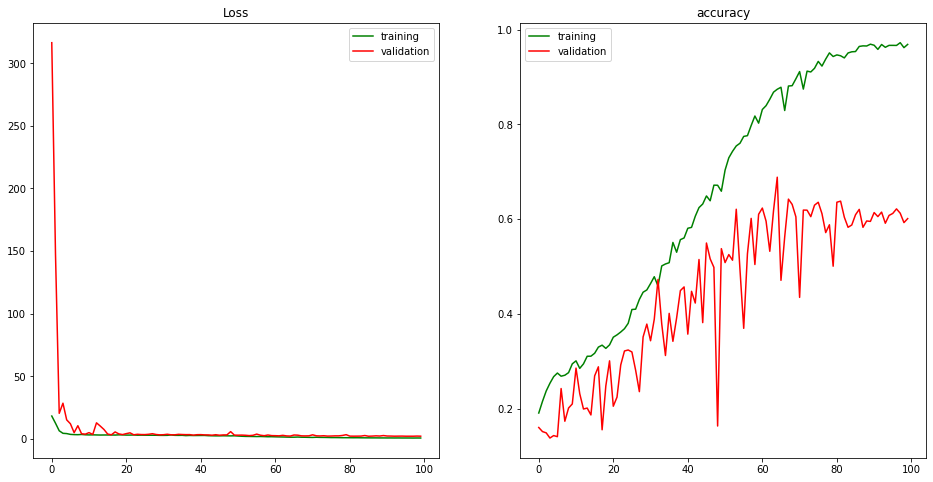

5863

In [22]:
plot_history(history1)
gc.collect()


# Model 2 : Densenet 121 base model.

In [23]:
#Model 2

#params:
Epochs2=100
batch_size2=32
filepath2='DenseNet_model.hdf5'

#model2
model2=DenseNet()

model2.compile(optimizer=keras.optimizers.Nadam(lr=1e-2),loss='categorical_crossentropy',
              metrics=[LWLRAP(24)])
#callbacks:

#reduce_lr
reduce_lr=keras.callbacks.ReduceLROnPlateau(patience=3,factor=0.75,min_delta=1e-2,monitor='val_loss',verbose=0,min_lr=1e-8)

#early stopping
# early_stopping=keras.callbacks.EarlyStopping(patience=25,min_delta=1e-3,monitor='val_lwlrap',restore_best_weights=True)

#save model:
# checkpoint2 = keras.callbacks.ModelCheckpoint(filepath2, monitor='val_lwlrap', verbose=1,
#                                                 save_best_only=True, mode='max')    
gc.collect()

29089792/29084464 [==============================] - 0s 0us/step


17029

In [24]:
#training model2:

history2=model2.fit(X,y,validation_split=0.05,callbacks=[reduce_lr],
                   epochs=Epochs2,batch_size=batch_size2,shuffle=True,verbose=1)
gc.collect()

Epoch 1/100
32/32 [==============================] - 51s 630ms/step - loss: 4.0935 - lwlrap: 0.1650 - val_loss: 538209566064640.0000 - val_lwlrap: 0.1203
Epoch 2/100
32/32 [==============================] - 16s 502ms/step - loss: 3.5468 - lwlrap: 0.1750 - val_loss: 2482039.2500 - val_lwlrap: 0.1500
Epoch 3/100
32/32 [==============================] - 16s 496ms/step - loss: 3.2857 - lwlrap: 0.1977 - val_loss: 6031.8179 - val_lwlrap: 0.1942
Epoch 4/100
32/32 [==============================] - 16s 502ms/step - loss: 3.1539 - lwlrap: 0.2093 - val_loss: 24.0440 - val_lwlrap: 0.2411
Epoch 5/100
32/32 [==============================] - 16s 498ms/step - loss: 3.1179 - lwlrap: 0.2203 - val_loss: 12.2677 - val_lwlrap: 0.2267
Epoch 6/100
32/32 [==============================] - 16s 504ms/step - loss: 3.0709 - lwlrap: 0.2261 - val_loss: 4.6140 - val_lwlrap: 0.2636
Epoch 7/100
32/32 [==============================] - 16s 498ms/step - loss: 3.0120 - lwlrap: 0.2428 - val_loss: 3.6816 - val_lwlrap: 0.

2069

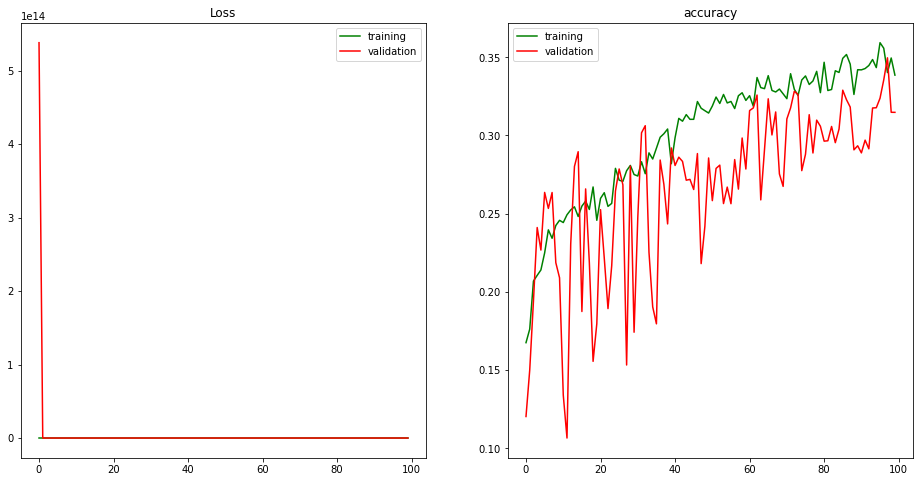

5863

In [25]:
plot_history(history2)
gc.collect()

# Inference:
The test code is almost entirely from this notebook: [ https://www.kaggle.com/stegzz/readable-keras-resnet50-model ]

In [26]:
def create_test_spec(audio, shape, sr=44200, power=2.0, third_dim=True):
    '''
    docstring here
    '''
    
    # initialize list 
    final_list = []
    # break audio into 10 seconds sub arrays
    audio = np.split(audio, 10)

    # loop through sub arrays
    for sub_array in audio:

        stft = librosa.feature.melspectrogram(sub_array, sr=sr, power=power, fmin=min_freq, fmax=max_freq, n_mels=shape_1[0])
        stft_to_db = librosa.core.amplitude_to_db(np.abs(stft))

        # resize array
        stft_to_db = resize(stft_to_db, shape)

        # normalize 
        stft_to_db = stft_to_db - np.min(stft_to_db)
        stft_to_db = stft_to_db / np.max(stft_to_db)
    
    
        if third_dim == True:
            stft_to_db = np.stack((stft_to_db,stft_to_db,stft_to_db))
        
        # reshape output
        stft_to_db = stft_to_db.reshape(stft_to_db.shape[1], stft_to_db.shape[2], stft_to_db.shape[0])
        
        # append stft_to_db to list
        final_list.append(stft_to_db)
    


    return(final_list)



# Predicting:

In [27]:

# get test headers from sample_submission.csv
temp = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
cols = temp.columns.tolist()

# initialize list
prediction_list = []

# loop through test files
test_path = '../input/rfcx-species-audio-detection/test'

for root, dirs, files in os.walk(test_path):
    
    # get total number of files for progress report
    total = len(files)
    
    # loop through files 
    for file in files:
        
        # load in audio
        loaded_audio, sample_rate = librosa.load(test_path+'/'+file, sr=None)
        
        # pass loaded_audio to create_test_spec function
        test_list = create_test_spec(loaded_audio, shape=shape_1, power=2)
        
        # get predictions
        preds =(0.5 * model1.predict(np.array(test_list)))+(0.5 * model2.predict(np.array(test_list)))         
        
        # get mean prediction probabilities
        mean_preds = np.mean(preds, axis=0)
        
        # append mean probs to list
        prediction_list.append(mean_preds) 
        
# convert final list to dataframe --> this is messy and needs to be cleaned up
sub_df = pd.DataFrame({cols[0]:files})
cols2 = cols[1:]
temp_df= pd.DataFrame(prediction_list, columns=cols2)
temp_df['recording_id']=files
sub_df = temp_df[cols]

# eliminate file extension
sub_df['recording_id'] = sub_df['recording_id'].str.replace(r'.flac$','')


In [28]:
sub_df.head()

recording_id        s0        s1        s2        s3        s4        s5  \
0    57d1671d3  0.087551  0.073222  0.031887  0.029441  0.025246  0.316944   
1    e3cd63a21  0.043363  0.206951  0.018108  0.029366  0.035104  0.221852   
2    10fa28496  0.001445  0.000838  0.002334  0.006553  0.000411  0.431659   
3    56be676c0  0.024882  0.030387  0.025354  0.032792  0.021790  0.365141   
4    53bce4c90  0.060562  0.017630  0.079389  0.027024  0.062207  0.056427   

         s6        s7        s8  ...       s14       s15       s16       s17  \
0  0.004761  0.037614  0.017903  ...  0.026761  0.029715  0.038205  0.005617   
1  0.003131  0.015233  0.032794  ...  0.118899  0.019638  0.024920  0.003975   
2  0.058070  0.074706  0.000228  ...  0.001604  0.006067  0.004470  0.076604   
3  0.009252  0.019789  0.020560  ...  0.079752  0.077279  0.032961  0.011507   
4  0.020967  0.079934  0.011082  ...  0.020354  0.032394  0.035203  0.025505   

        s18       s19       s20       s21       s22       s23  
0  0.030578  0.019084  0.005806  0.019277  0.019178  0.065362  
1  0.037025  0.010486  0.002655  0.057094  0.010680  0.018521  
2  0.004670  0.007824  0.039141  0.000154  0.057808  0.091952  
3  0.021446  0.019716  0.006968  0.072267  0.015244  0.025368  
4  0.119035  0.031126  0.014961  0.111749  0.020172  0.056835  

[5 rows x 25 columns]

In [29]:
# create submission .csv
sub_df.to_csv('./submission.csv',index=False)